<a href="https://colab.research.google.com/github/stefan9988/satellite_image_building_detection/blob/main/Building_Mapping_massachusetts_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building Mapping


In [ ]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tifffile as tiff
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, BatchNormalization, Add
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# set the working directory
import os
os.chdir(r'/content/gdrive/MyDrive/archive/tiff')

## Data preprocessing

In [ ]:
def split_image(input_image_path, size=128):
    img = tiff.imread(input_image_path)
    height, width, num_channels = img.shape

    num_rows = height // size
    num_cols = width // size

    result_array = np.zeros((num_rows * num_cols, size, size, num_channels), dtype=img.dtype)

    idx = 0
    for row in range(num_rows):
        for col in range(num_cols):
            left = col * size
            top = row * size
            right = left + size
            bottom = top + size

            for channel in range(num_channels):
                cropped_img = img[top:bottom, left:right, channel]
                result_array[idx, :, :, channel] = cropped_img

            # plt.imshow(result_array[idx,:,:,:3])
            # plt.show()
            idx += 1

    return result_array[:,:,:,:3],num_rows,num_cols

In [ ]:
img_path = '/content/gdrive/MyDrive/archive/tiff/test_labels/22828930_15.tif'

# Load the image using PIL
img = tiff.imread(img_path)

# Convert the image to a NumPy array
ns_array = np.array(img)

# Print the shape, minimum, and maximum values
print("Shape of the array:", ns_array.shape)
print("Minimum value:", np.min(ns_array))
print("Maximum value:", np.max(ns_array))

# x,y,z = split_image(img_path)
# x.shape

Shape of the array: (1500, 1500, 3)
Minimum value: 0
Maximum value: 255


In [ ]:
train_x = sorted(glob.glob('train/*.tiff'))
train_y = sorted(glob.glob('train_labels/*.tif'))
val_x = sorted(glob.glob('val/*.tiff'))
val_y = sorted(glob.glob('val_labels/*.tif'))
test_x = sorted(glob.glob('test/*.tiff'))
test_y = sorted(glob.glob('test_labels/*.tif'))

print(len(train_x), len(val_x), len(test_x))
print(len(train_y), len(val_y), len(test_y))

137 4 10
137 4 10


In [ ]:
# converting training images to numpy array
# train_x = train_x[:10]
# train_y = train_y[:10]

# train_xx = np.zeros((len(train_x), 1500, 1500, 3))
# train_yy = np.zeros((len(train_y), 1500, 1500, 3))

for i, img_path in enumerate(train_x):
    # train_xx[i, :, :, :] = tiff.imread(img_path)
    np_img, _, _ = split_image(img_path)
    if i == 0:
      train_xx = np_img
    else:
      train_xx = np.concatenate((train_xx, np_img), axis=0)

for i, img_path in enumerate(train_y):
    # train_yy[i, :, :, :] = tiff.imread(img_path)
    np_img, _, _ = split_image(img_path)
    if i == 0:
      train_yy = np_img
    else:
      train_yy = np.concatenate((train_yy, np_img), axis=0)


In [ ]:
# converting val images to numpy array
# val_xx = np.zeros((len(val_x), 128, 128, 3))
# val_yy = np.zeros((len(val_x), 128, 128, 1))

for i, img_path in enumerate(val_x):
    # val_xx[i, :, :, :] = tiff.imread(img_path)
    np_img, _, _ = split_image(img_path)
    if i == 0:
      val_xx = np_img
    else:
      val_xx = np.concatenate((val_xx, np_img), axis=0)

for i, img_path in enumerate(val_y):
    # val_yy[i, :, :, :] = tiff.imread(img_path)
    np_img, _, _ = split_image(img_path)
    if i == 0:
      val_yy = np_img
    else:
      val_yy = np.concatenate((val_yy, np_img), axis=0)

In [ ]:
# converting test images to numpy array
# test_xx = np.zeros((len(val_x), 128, 128, 3))
# test_yy = np.zeros((len(val_x), 128, 128, 1))
for i, img_path in enumerate(test_x):
    # test_xx[i, :, :, :] = tiff.imread(img_path)
    np_img, _, _ = split_image(img_path)
    if i == 0:
      test_xx = np_img
    else:
      test_xx = np.concatenate((test_xx, np_img), axis=0)

for i, img_path in enumerate(test_y):
    # test_yy[i, :, :, :] = tiff.imread(img_path)
    np_img, _, _ = split_image(img_path)
    if i == 0:
      test_yy = np_img
    else:
      test_yy = np.concatenate((test_yy, np_img), axis=0)

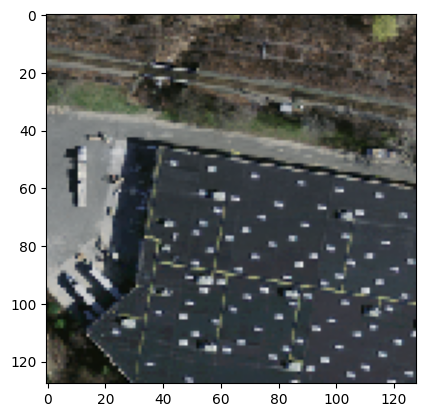

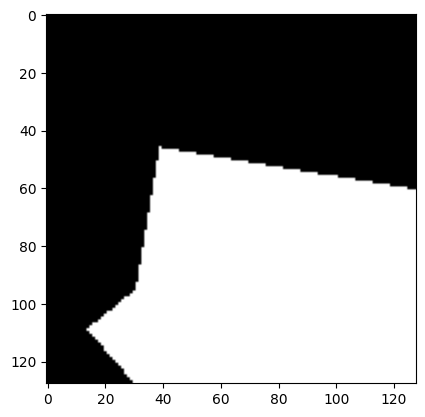

In [ ]:
plt.imshow(train_xx[6, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[6, :, :, :].astype('uint8'))
plt.show()

## Image augmentation

In [ ]:
# def augment_image(image_1, image_2, flip=True, rotate=True, zoom=True):
#     # Flip the image horizontally
#     if flip:
#         image_1 = cv2.flip(image_1, 1)
#         image_2 = cv2.flip(image_2, 1)
#         image_2 = image_2[:, :, np.newaxis]

#     # Rotate the image by a random angle between -45 and 45 degrees
#     if rotate:
#         angle = np.random.uniform(-45, 45)

#         rows, cols, _ = image_1.shape
#         rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
#         image_1 = cv2.warpAffine(image_1, rotation_matrix, (cols, rows))

#         rows, cols, _ = image_2.shape
#         rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
#         image_2 = cv2.warpAffine(image_2, rotation_matrix, (cols, rows))
#         image_2 = image_2[:, :, np.newaxis]

#     # Zoom into the image by a random factor between 1.0 and 1.5
#     if zoom:
#         zoom_factor = np.random.uniform(1.0, 1.5)

#         rows, cols, _ = image_1.shape
#         zoom_matrix = np.array([[zoom_factor, 0, (1 - zoom_factor) * cols / 2],
#                                 [0, zoom_factor, (1 - zoom_factor) * rows / 2]])
#         image_1 = cv2.warpAffine(image_1, zoom_matrix, (cols, rows))

#         rows, cols, _ = image_2.shape
#         zoom_matrix = np.array([[zoom_factor, 0, (1 - zoom_factor) * cols / 2],
#                                 [0, zoom_factor, (1 - zoom_factor) * rows / 2]])
#         image_2 = cv2.warpAffine(image_2, zoom_matrix, (cols, rows))
#         image_2 = image_2[:, :, np.newaxis]

#     return image_1, image_2

In [ ]:
# augmented_image_1, augmented_image_2 = augment_image(train_xx[20, :, :, :], train_yy[20, :, :, :], 1,1,1)

In [ ]:
# plt.imshow(augmented_image_1.astype('uint8'))
# plt.show()
# plt.imshow(augmented_image_2.astype('uint8'))
# plt.show()

In [ ]:
# n=500
# augmented_train_xx = np.zeros((n,128,128,3))
# augmented_train_yy = np.zeros((n,128,128,1))

# for i in range(n):
#   img_number = random.randint(0, 69)
#   augmented_image_1, augmented_image_2 = augment_image(train_xx[img_number, :, :, :], train_yy[img_number, :, :, :], random.choice([0, 1]),random.choice([0, 1]),random.choice([0, 1]))
#   augmented_train_xx[i,:,:,:] = augmented_image_1
#   augmented_train_yy[i,:,:,:] = augmented_image_2

In [ ]:
# for i in range(0,500,100):
#   plt.imshow(augmented_train_xx[i, :, :, :].astype('uint8'))
#   plt.show()
#   plt.imshow(augmented_train_yy[i, :, :, 0].astype('uint8'))
#   plt.show()

## Create model

In [ ]:
def create_model():
  x_in = tf.keras.layers.Input(shape=(128, 128, 3))

  '''Encoder'''
  x_temp = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
  x_temp = tf.keras.layers.Dropout(0.2)(x_temp)
  x_skip1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.MaxPooling2D((2,2))(x_skip1)
  x_temp = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.2)(x_temp)
  x_skip2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.MaxPooling2D((2,2))(x_skip2)
  x_temp = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.2)(x_temp)
  x_skip3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.MaxPooling2D((2,2))(x_skip3)
  x_temp = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.1)(x_temp)
  x_temp = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

  '''Decoder'''
  x_temp = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.2)(x_temp)
  x_temp = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Concatenate()([x_temp, x_skip3])
  x_temp = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.1)(x_temp)
  x_temp = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Concatenate()([x_temp, x_skip2])
  x_temp = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.2)(x_temp)
  x_temp = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Concatenate()([x_temp, x_skip1])
  x_temp = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
  x_temp = tf.keras.layers.Dropout(0.1)(x_temp)
  x_temp = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

  '''Use 1 by 1 Convolution to get desired output bands'''
  x_temp = tf.keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
  x_temp = tf.keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
  x_out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
  # use sigmoid activation here because output values are either 0 or 1

  model = tf.keras.models.Model(inputs=x_in, outputs=x_out)
  return model

## Test model

In [ ]:
# model = create_model()

In [ ]:
# model.summary()

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# checkpoint_callback = ModelCheckpoint(
#     filepath='mas_test.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

In [ ]:
train_yy[train_yy == 255] = 1
val_yy[val_yy == 255] = 1
test_yy[test_yy == 255] = 1

In [ ]:
train_yy = train_yy[:,:,:,:1]
val_yy = val_yy[:,:,:,:1]
test_yy = test_yy[:,:,:,:1]

train_yy = train_yy.astype(float)
val_yy = val_yy.astype(float)
test_yy = test_yy.astype(float)


In [ ]:
# # training model
# # history = model.fit(augmented_train_xx, augmented_train_yy, validation_data=(test_xx, test_yy), epochs=150, batch_size=50, callbacks=[checkpoint_callback], verbose=1)
# history = model.fit(train_xx, train_yy, validation_data=(val_xx, val_yy), epochs=50, batch_size=100, callbacks=[checkpoint_callback], verbose=1)

In [ ]:
# # plot model loss over training and validation data
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Prediction

In [ ]:
# threshold = 0.5
# im = 12

# # prediction of the output
# pred_test = model.predict(test_xx)
# pred_test = (pred_test > threshold).astype(np.uint8)
# print(pred_test.shape)

# #let's comare random predicted and actial y values
# plt.imshow(pred_test[im, :, :, 0])
# plt.show()
# plt.imshow(test_yy[im,:,:,0])
# plt.show()

## Main Model Training

In [ ]:
# xx = result = np.concatenate((train_xx, val_xx), axis=0)
# yy = result = np.concatenate((train_yy, val_yy), axis=0)

In [ ]:
# n=7000
# augmented_xx = np.zeros((n,128,128,3))
# augmented_yy = np.zeros((n,128,128,1))

# for i in range(n):
#   img_number = random.randint(0, 99)
#   augmented_image_1, augmented_image_2 = augment_image(xx[img_number, :, :, :], yy[img_number, :, :, :], random.choice([0, 1]),random.choice([0, 1]),random.choice([0, 1]))
#   augmented_xx[i,:,:,:] = augmented_image_1
#   augmented_yy[i,:,:,:] = augmented_image_2

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='mas_model_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
model = create_model()
model.load_weights('mas_model_weights.h5')
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# training model
history = model.fit(train_xx,train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=100, callbacks=[checkpoint_callback], verbose=1)

Epoch 1/100
166/166 [==============================] - ETA: 0s - loss: 0.3052
Epoch 1: val_loss improved from inf to 0.31452, saving model to mas_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 109s 515ms/step - loss: 0.3052 - val_loss: 0.3145
Epoch 2/100
166/166 [==============================] - ETA: 0s - loss: 0.2328
Epoch 2: val_loss improved from 0.31452 to 0.26247, saving model to mas_model_weights.h5
166/166 [==============================] - 75s 449ms/step - loss: 0.2328 - val_loss: 0.2625
Epoch 3/100
166/166 [==============================] - ETA: 0s - loss: 0.2070
Epoch 3: val_loss improved from 0.26247 to 0.23184, saving model to mas_model_weights.h5
166/166 [==============================] - 75s 449ms/step - loss: 0.2070 - val_loss: 0.2318
Epoch 4/100
166/166 [==============================] - ETA: 0s - loss: 0.1943
Epoch 4: val_loss improved from 0.23184 to 0.21888, saving model to mas_model_weights.h5
166/166 [==============================] - 75s 449ms/step - loss: 0.1943 - val_loss: 0.2189
Epoch 5/100
166/166 [==============================] - ETA: 0s - loss: 0.1883
Epoch 5: val_loss improved from 0.21888 to 0.20393, 

In [ ]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## NS image


In [ ]:
# Assuming you have the path to the image stored in 'ns'
ns_path = '/content/gdrive/MyDrive/archive/SnimakNS.tif'

# Load the image using PIL
img = tiff.imread(ns_path)

# Convert the image to a NumPy array
ns_array = np.array(img)

# Print the shape, minimum, and maximum values
print("Shape of the array:", ns_array.shape)
print("Minimum value:", np.min(ns_array))
print("Maximum value:", np.max(ns_array))

Shape of the array: (5911, 10657, 5)
Minimum value: 0
Maximum value: 255


In [ ]:
for i in range(5):
  plt.imshow(ns_array[:, :, i])
  plt.show()

# 5 ti kanal ima vrednost 255 za svaki piksel

In [ ]:
def split_image(input_image_path, size=128):
    img = tiff.imread(input_image_path)
    height, width, num_channels = img.shape

    num_rows = height // size
    num_cols = width // size

    result_array = np.zeros((num_rows * num_cols, size, size, num_channels), dtype=img.dtype)

    idx = 0
    for row in range(num_rows):
        for col in range(num_cols):
            left = col * size
            top = row * size
            right = left + size
            bottom = top + size

            for channel in range(num_channels):
                cropped_img = img[top:bottom, left:right, channel]
                result_array[idx, :, :, channel] = cropped_img

            # plt.imshow(result_array[idx,:,:,:3])
            # plt.show()
            idx += 1

    return result_array[:,:,:,:3],num_rows,num_cols

In [ ]:
def reconstruct_image(result_array, num_rows, num_cols, size=128):
    num_samples, size, _, num_channels = result_array.shape

    reconstructed_image = np.zeros((num_rows * size, num_cols * size, num_channels), dtype=result_array.dtype)

    idx = 0
    for row in range(num_rows):
        for col in range(num_cols):
            left = col * size
            top = row * size
            right = left + size
            bottom = top + size

            for channel in range(num_channels):
                cropped_img = result_array[idx, :, :, channel]
                reconstructed_image[top:bottom, left:right, channel] = cropped_img

            idx += 1

    return reconstructed_image

In [ ]:
def save_img(sample_array,img_name,grayscale = False):
  if grayscale:
    sample_array = sample_array * 255
    image = Image.fromarray(sample_array.squeeze(), mode='L')
  else:
    image = Image.fromarray(sample_array.astype('uint8'))

  image.save(f'{img_name}.png')

In [ ]:
ns_splited,num_rows,num_cols = split_image(ns_path)
print(ns_splited.shape)

(3818, 128, 128, 3)


In [ ]:
model = create_model()
model.load_weights('mas_model_weights.h5')

In [ ]:
threshold = 0.5

# prediction of the output
pred_ns = model.predict(ns_splited)
pred_ns = (pred_ns > threshold).astype(np.uint8)

120/120 [==============================] - 294s 2s/step


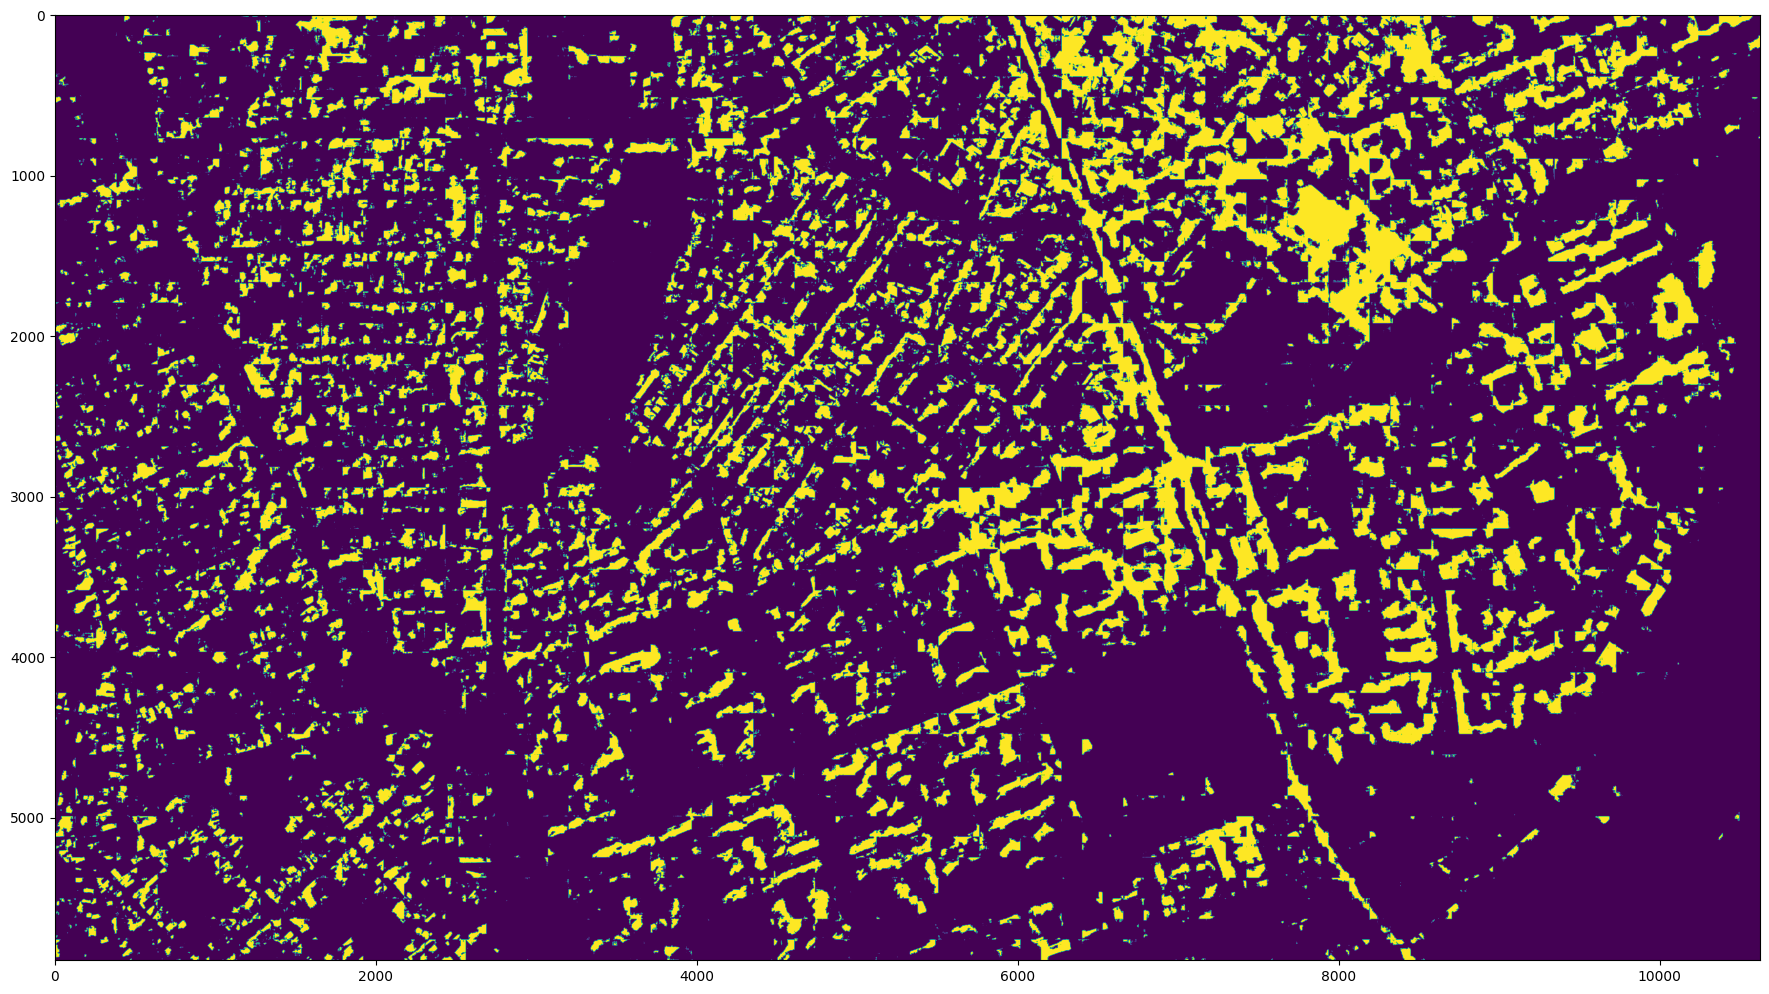

In [ ]:
reconstructed_image = reconstruct_image(pred_ns,num_rows,num_cols)
plt.figure(figsize=(22, 20))
plt.imshow(reconstructed_image)
plt.show()
# save_img(reconstructed_image,'NS_th_05_mas', True)

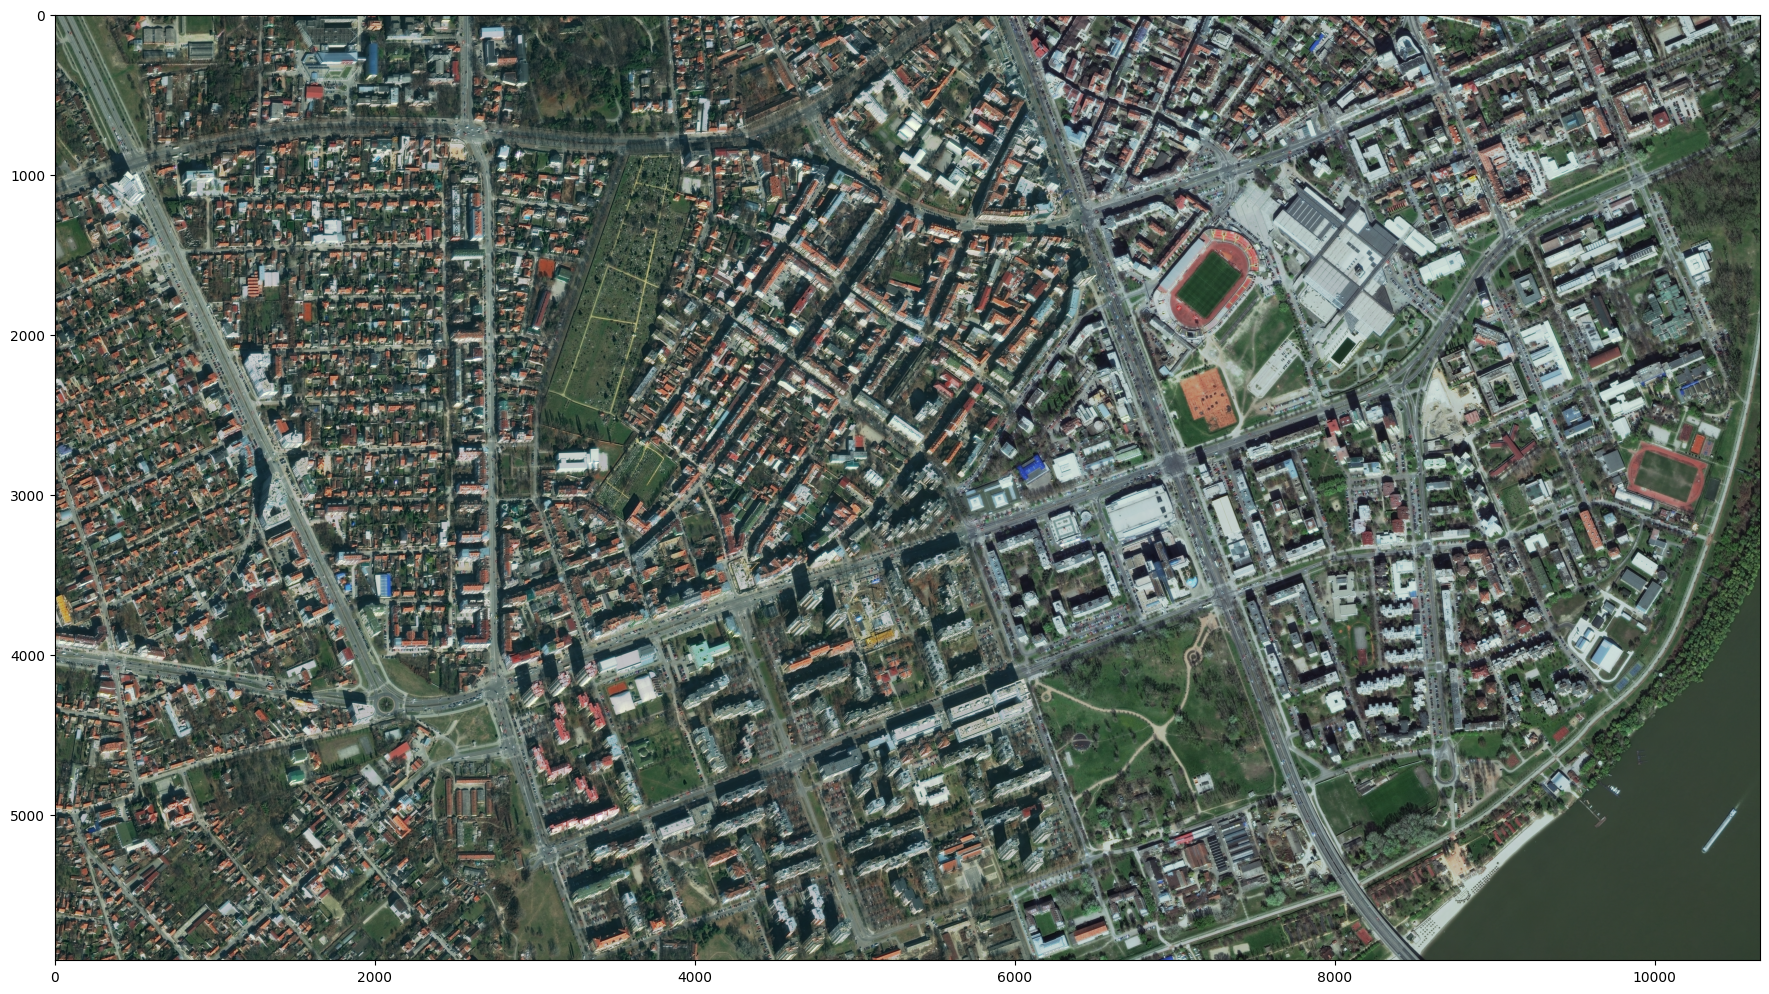

In [ ]:
plt.figure(figsize=(22, 20))
plt.imshow(ns_array[:, :, :3])
plt.show()
# save_img(ns_array[:, :, :3],'NS_RGB')

## Filtering


In [ ]:
import cv2
import numpy as np

def remove_noise_binary(image_path, kernel_size=3, save_path=None):
    # Read the binary image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a median filter to remove noise
    filtered_image = cv2.medianBlur(image, kernel_size)

    # Threshold the filtered image to get a binary result
    _, binary_result = cv2.threshold(filtered_image, 127, 255, cv2.THRESH_BINARY)

    if save_path:
        cv2.imwrite(save_path, binary_result)


    return binary_result

In [ ]:
from google.colab.patches import cv2_imshow
# Example usage:
input_image_path = 'NS_th_05_mas.png'
output_image = remove_noise_binary(input_image_path, 15, 'NS_th_05_mas_filtered.png')

cv2_imshow(output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()